The new C++ implementation extends functionality in the following major aspects:
* immunity decline curve for SIRS implementation 
* Country-level (multi-cities) models
* the phenomenological dynamics of the virus variants' $r_0$ changes (mutations model) 

Due to extended functionality, the Python interface to the C++ implementation has numerous new parameters to be explained later.

In [1]:
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
plt.style.use('seaborn-whitegrid')

In [2]:
def exec_SIR(r0_0,I0,τ,vs0,vb0,T=12.0,
             vcb=0.4,nlp=0.125,tp=0.01,elr=5.0,ps=80000,
             sn=30,mtl=100,seed=317,
             exec_type=0,is_country=0,ao=0,
             s_rate=0.0,ilp=1.0,pii=2.,nnmp=0.0,
             cn=10000,θ=0.1,θ_r=0.1,θ_v=0.05,
             ze=1.07,isp=1./128.,dir='c:\\tmp'):
    command=f'stochastic2.exe -d"{dir}"'
    with open(dir+"\\config.txt", "rt") as file:
        conf=dict(np.loadtxt(file,dtype=('U32,f8')))
        
    conf["final_time"]=T
    conf["simulations_number"]=sn
    conf["min_trace_len"]=mtl
    conf["resample_step"]=t_step
    conf["population_size"]=ps
    conf["initial_R0"]=r0_0
    conf["variance_of_social_activity"]=vs0
    conf["variance_of_catchability"]=vb0
    conf["variance_of_spreadability"]=vcb
    conf["inverse_tau"]=1.0/τ
    conf["new_lineage_prob"]=nlp
    conf["test_prob"]=tp
    conf["external_lineages_rate"]=elr
    conf["nonneutral_mutation_prob"]=nnmp

    #if seed is 0 it automatically randomized
    conf["initial_seed"]=seed
    
    #exec_type
    #0 - most commonn dynamics & lineage tests distribution defining by other params 
    #1 - SIRS dynamics with decline curves test
    #2 - country level model test
    #3 - mutations indused r0 dynamics test for city level model
    conf["exec_type"]=exec_type
    #for exec_type==0 define city(0)/country(1) level model
    conf["is_country_level"]=is_country
    #for exec_type==0 define additional to S,I output (for example city quartiles' dynamics)
    conf["additional_output"]=ao
    
    #susceptibility recover rate
    #immunity decline curve
    conf["immunity_loss_rate"]=s_rate
    conf["immunity_loss_power"]=ilp
    conf["protective_immunity_interval"]=pii
    
    #for country SIR dynamics
    conf["number_of_cities"]=cn
    conf["theta_city_attraction"]=θ
    conf["theta_city_R0"]=θ_r
    conf["theta_city_sa_variance"]=θ_v
    conf["zipf_exponent"]=ze
    conf["intercity_spread_probability"]=isp
    
    with open(dir+"\\config.txt", "wt") as file:
        for k in conf:
            file.write(f'{k} {conf[k]}\n')
    time.sleep(1)        
    return os.system(command)

def dynamics_from_file(I0,l_m=100,path="c:\\tmp"):
    with open(path+"\\dynamics.txt", "rt") as file:
        trace_numb,T,S,I=np.loadtxt(file).T
    resT,resS,resI=[],[],[]
    l_min=100000000;
    TN=int(trace_numb[-1])+1
    for tn in range(TN):
        mask=(trace_numb==tn)
        t,s,i=T[mask],S[mask],I[mask]
        N=s[0]+i[0]
        s/=N
        i/=N
        pos=np.argmax(i>I0)
        l=len(t)-pos-1
        if l<l_m:continue #throw out too short traces
        if(l<l_min):l_min=l
        resT.append(t[pos:]-t[pos])
        resS.append(s[pos:])
        resI.append(i[pos:])
    for tn in range(len(resT)):
        resT[tn]=resT[tn][:l_min]
        resS[tn]=resS[tn][:l_min]
        resI[tn]=resI[tn][:l_min]
    return np.vstack(resT), np.vstack(resS),np.vstack(resI) 


## Immunity decline curve

Previous implementation assumes susceptibility (abruptly) fully returned after recovery within (in average) 1/s_rate units of time. All the persons in $R$ecovered comparment have a s_rate ($s_r$) probability per time unit to be moved to $S$usceptible compartment. Thus, the expected probability for an infection receiver to not be reinfected in an infection event (the event involves an infection spreader and receiver, and a susceptible receiver surely gets infected) is
$$D(\Delta t)=\exp(-s_r\Delta t)$$
where $\Delta t$- time from the receiver recovery. We have exponetial (expected) immunity decline in this model. 

To have more immunity decline curves, we change the model. Instead of moving recovered from the R compartment (where all are immune and noninfectible) to S, which corresponds to the disappearance of immunity, we allow recovered to be infected in an infection event with probability dependent on time from the recovery (SIRI instead of the SIRS model):
$$p_{inf}=1-D(\Delta t)$$
where $D(\Delta t)$ - immunity decline curve defined by immunity loss rate $s_r$ and some other parameters. First, we add the protective immunity interval $i_p$ - a time after the recovery when immunity stays strong and reinfection is impossible. Second, we use power $P$ transformed $s_r\Delta t$:

$$
D(\Delta t) = \begin{cases} 
1 & \Delta t \le i_p\\ 
f((s_r(\Delta t-i_p))^P) & \text{otherwise} 
\end{cases}
$$

$f(x)$ can be any nonencreasing function equal to 1 at zero. We consider $f(x)=exp(-x)$ as a natural choice. Another obvious candidate is the polynomial variant $f(x)=1/(1+x^2)$. Finally, we stick with:

$$
D(\Delta t) = \begin{cases} 
1 & \Delta t \le i_p \\ 
\exp(-(s_r(\Delta t-i_p))^P) & \text{otherwise}
\end{cases}
$$

here <br>
$s_r$ - immunity loss rate (s_rate parameter in python function)<br>
$P$ - immunity loss power (ilp parameter in python function)<br>
$i_p$ - protective immunity interval (pii parameter in python function).

So, setting $i_p=0$ and $P=1$ we get the same expected immunity decline as the previous model has. Yet, the model's dynamics are a little different because it is defined not only by the expectation of immunity decline but also by more fine details of immunity disappearing.

Below is a comparison of (re)infection dynamics for exponential ($P=1$) and "Gaussian" ($P=2$) immunity declines.

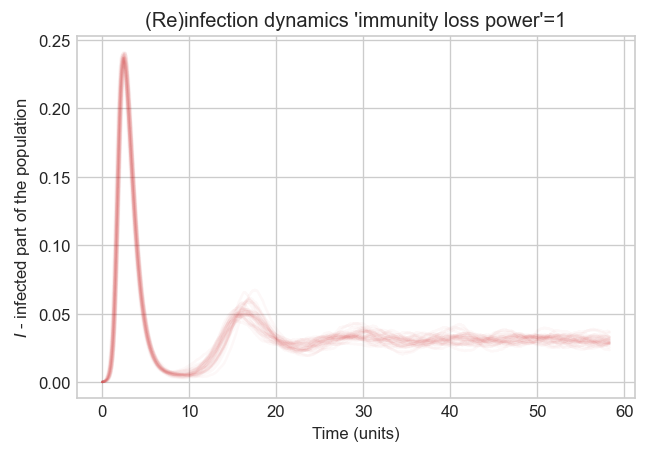

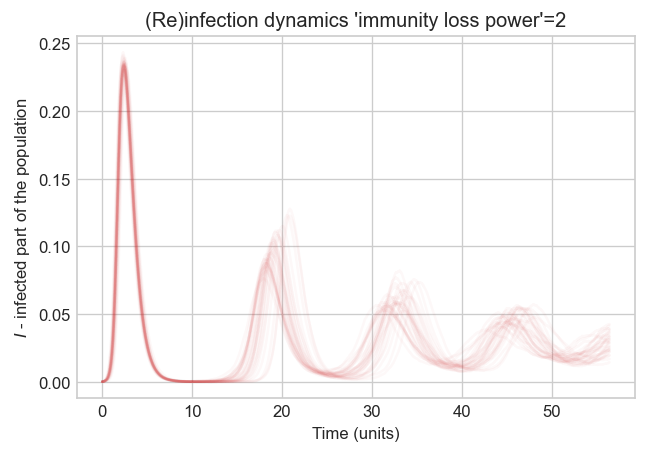

In [3]:
T=60.0
t_step=0.01
min_step_n=int(0.9*T/t_step);
vs0=0.5
vb0=0.4
r0_0=5.2
I0=0.0002
τ=0.4
exec_SIR(r0_0,I0,τ,vs0,vb0,ps=200000,T=T,s_rate=0.08,pii=0.0,ilp=1.0,mtl=min_step_n,exec_type=1)
T_,S_,I_=dynamics_from_file(I0);
fig, ax = plt.subplots(dpi=120)
plt.title("(Re)infection dynamics 'immunity loss power'=1")
for t,i in zip(T_,I_):
    plt.plot(t, i,color='C3', alpha=0.03)
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

exec_SIR(r0_0,I0,τ,vs0,vb0,ps=200000,T=T,s_rate=0.08,pii=0.0,ilp=2.0,mtl=min_step_n,exec_type=1)
T_,S_,I_=dynamics_from_file(I0);
fig, ax = plt.subplots(dpi=120)
plt.title("(Re)infection dynamics 'immunity loss power'=2")
for t,i in zip(T_,I_):
    plt.plot(t, i,color='C3', alpha=0.03)
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()



From the first look, clear waves, which we can see in real COVID-19 dynamics, is an argument in favor of a large enough $P$ value. Yet, real dynamics are strongly influenced by differences in COVID-19 strains, public measures, and seasonal changes that make the first-look arguments inconclusive.

The implementation allows the complexity of the decline model to further increase, making it dependent on spreader (current) and receiver (previous) virus variants, thus taking into account cross-immunity effects.  

## Country level models

A country-level model is implemented as a multi-city environment. Being restricted to only one of the cities, the model should produce the same exact dynamics as the previous model with the corresponding city parameters. The key difference is that intercity dynamics are controlled by the "intercity spread probability" model parameter $p_i$. The spreader should seek the infection receiver within its own city (with a probability of $1-p_i$) or in any other city (with a probability of $p_i$) at each step of the spread simulation. Actually, the procedure is implemented in a different way, namely: with probability $p_i'$, the spreader selects the infection receiver in the whole country (proportional to a person's catchability), including his own city, and with probability $1-p_i'$, in its own city only. The value $p_i'$ for the given spreader city $j$ is calculated as
$$p_i'=p_i\frac{C}{C-C(j)}$$
where $C$ is the total catchability of all the country population and $C(j)$ is the sum of catchabilities of the spreader city population.

The distribution of the sizes ($z$) of the cities is controlled by Zipf's exponent $e_z$. The ratio of the sizes of the cities with ranks $i$ and $j$ is:
$$\frac{z_i}{z_j}\approx \left(\frac{j}{i}\right)^{e_z}$$

The most simple choice for $e_z$ is $1.0$. In this case,
$$\frac{z_i}{z_j}\approx \frac{j}{i},$$
specifically $z_1 \approx 2\,z_2$ -  largest city is twice as big as the second one.

We consider cities of various sizes to have the same "biological" part of disease-spreading parameters, while the "social" part differs. Large cities are more vulnerable to infection due to their greater attraction to intercity spreaders. The attraction is proportional to $z^\theta$ per inhabitant ($z^{1+\theta}$ for the whole city). Incity social contacts' intensity (ISCI) is key to incity spread dynamics. Its expected value we consider proportional to $z^{\theta_r}$ ($\theta_r+1$ is so-called __[urban scaling exponent](https://doi.org/10.1073/pnas.0610172104)__). To keep track of ISCI heterogeneity (we consider ISCI lognormally distributed), the geometric coefficient of variation (GCV) is considered proportional to $z^{\theta_v}$.

For the lognormally distributed random variable $X \sim LogN(\mu,v)$ with PDF  
$$f_{X}(x,\mu,v)= \frac {1} {\sqrt{2\pi\,v}} \frac{1}{x} \exp\left( -\frac{(\ln x-\mu)^2}{2 v} \right)$$ 
GCV is given by the formula 
$$\exp(v)-1,$$ so for the city size $z$ we have
$$\exp(v)-1 \sim z^{\theta_v}.$$

We parameterize the country model by the values of $r_0(z_1)$ and $v_0(z_1)$ for the largest city (believing the city determines initial dynamics). Finally, for a city with a population of $z$ the parameters are:
$$r_0(z)=r_0(z_1) (z/z_1)^{\theta_r}$$
$$v_0(z)=\ln(1+(\exp(v_0(z_1))-1) (z/z_1)^{\theta_v})$$
where the first equation is due to $r_0$ being proportional to ISCI, which in turn is proportional to $z^{\theta_r}$.


The simulation procedure remains almost unchanged. We only need to pass (to the procedure) the object of a new CountryPopulation class with spredabilities and catchabilities initialized in a city-aware way and an appropriately implemented candidate_to_infect() member.

We can compare the country-level model with the city-level SIR model.

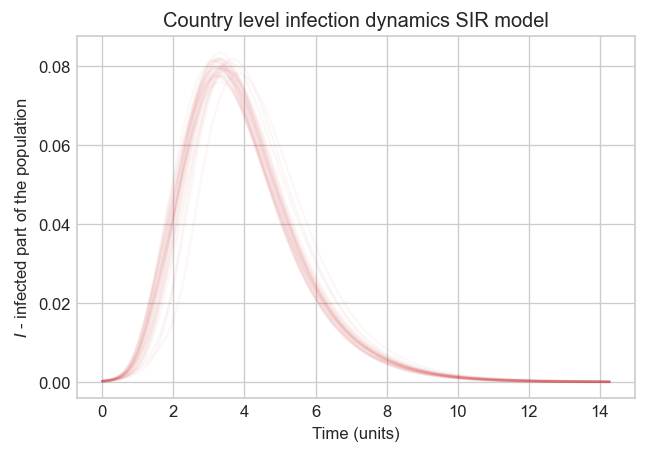

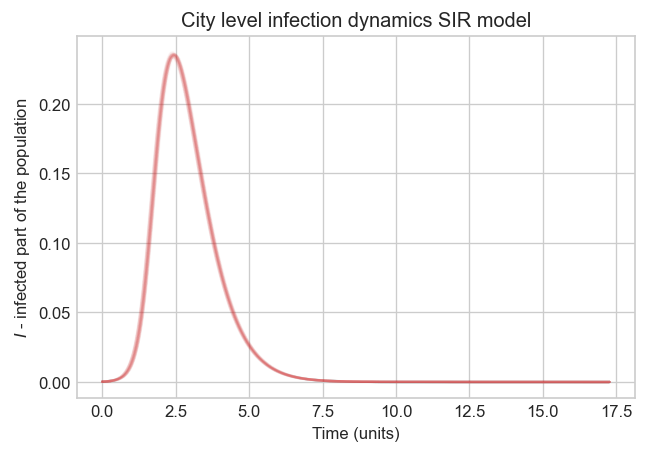

In [4]:
T=20.0
t_step=0.01
min_step_n=int(0.5*T/t_step);
vs0=0.5
vb0=0.4
r0_0=5.2
I0=0.0002
τ=0.4
number_of_cities=10000
zipf_exponent=1.0
intercity_spread_probability=1./32.
exec_SIR(r0_0,I0,τ,vs0,vb0,ps=2000000,T=T,mtl=min_step_n,elr=5,
         exec_type=2, #COUNTRY LEVEL MODEL
         s_rate=0.0,
         #below cities' population parameters
         cn=number_of_cities,ze=zipf_exponent, 
         θ=0.1,θ_r=0.1,θ_v=0.05,
         isp=intercity_spread_probability)
T_,S_,I_=dynamics_from_file(I0)
fig, ax = plt.subplots(dpi=120)
plt.title("Country level infection dynamics SIR model")
for t,i in zip(T_,I_):
    plt.plot(t, i,color='C3', alpha=0.03)
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()
exec_SIR(r0_0,I0,τ,vs0,vb0,ps=2000000,T=T,mtl=min_step_n,elr=5,
         exec_type=1, #CITY LEVEL SIRS MODEL
         s_rate=0.0, #making SIRS just SIR
         cn=number_of_cities,ze=zipf_exponent, 
         θ=0.1,θ_r=0.1,θ_v=0.05,
         
         isp=intercity_spread_probability)
T_,S_,I_=dynamics_from_file(I0)
fig, ax = plt.subplots(dpi=120)
plt.title("City level infection dynamics SIR model")
for t,i in zip(T_,I_):
    plt.plot(t, i,color='C3', alpha=0.03)
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

Also, we combine SIRS decline curves with country-level models and use flag is_country_level instead of exec_type, which will be zero, and the function will always produce lineages' test data (with exec_type=1 it doesn't produce the tests' data). 

In [5]:
T=60.0
is_country_level = 1
additional_output = 1
exec_SIR(r0_0,I0,τ,vs0,vb0,ps=2000000,T=T,mtl=min_step_n,
         exec_type=0, #indicates that model type defined by combination of another flags
         is_country=is_country_level,ao=additional_output,
         s_rate=0.08,pii=0.0,ilp=2.0, #immunity decline parameters
         #below cities' population parameters
         cn=number_of_cities,ze=zipf_exponent, 
         θ=0.1,θ_r=0.1,θ_v=0.05,
         isp=intercity_spread_probability)

0

We have added the possibility to track not only the infection dynamics for the whole country's population but also the population quartile dynamics, i.e., for big, middle, small, and tiny cities separately.  

We modified the output functionality so that the quartile dynamics were saved in a separate file. The additional_output flag specifies whether the file should be written. To read the file, we'll also need a Python procedure.

In [6]:
def quartile_dynamics_from_file(I0,l_m=100,path="c:\\tmp"):
    SI=np.empty(8,dtype=object)
    si=np.empty(8,dtype=object)
    with open(path+"\\qdynamics.txt", "rt") as file:
        trace_numb,T,SI[0],SI[1],SI[2],SI[3],SI[4],SI[5],SI[6],SI[7]=np.loadtxt(file).T
    res=[[],[],[],[],[],[],[],[],[]]    
    l_min=100000000;
    TN=int(trace_numb[-1])+1
    for tn in range(TN):
        mask=(trace_numb==tn)
        t=T[mask]
        for col in range(8):
            si[col]=SI[col][mask]
        NN=np.zeros(4)
        N=0
        for col in range(4):
            NN[col]=si[col][0]+si[col+4][0]
            N += NN[col]
        pos=np.argmax((si[4]+si[5]+si[6]+si[7])>I0*N)
        l=len(t)-pos-1
        if l<l_m:continue
        if(l<l_min):l_min=l 
        res[0].append(t[pos:]-t[pos])
        for col in range(8):
            res[col+1].append(si[col][pos:]/NN[col%4])
    for tn in range(len(res[0])):
        for col in range(9):
            res[col][tn]=res[col][tn][:l_min]
    return (np.vstack(res[col]) for col in range(9)) 


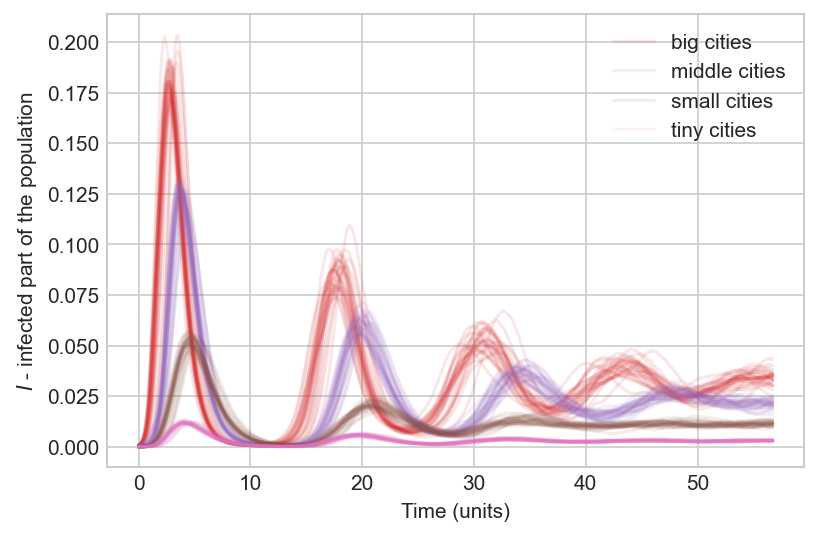

In [7]:
qT,qS1,qS2,qS3,qS4,qI1,qI2,qI3,qI4=quartile_dynamics_from_file(I0)
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI1)):
    plt.plot(t, i,color='C3', alpha=0.1, label=None if n else f'big cities')
for n,(t,i) in enumerate(zip(qT,qI2)):
    plt.plot(t, i,color='C4', alpha=0.1, label=None if n else f'middle cities')
for n,(t,i) in enumerate(zip(qT,qI3)):
    plt.plot(t, i,color='C5', alpha=0.1, label=None if n else f'small cities')
for n,(t,i) in enumerate(zip(qT,qI4)):
    plt.plot(t, i,color='C6', alpha=0.1, label=None if n else f'tiny cities')
plt.legend(loc='upper right')
#x.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

It may be better to look at the picture on a log-y scale.

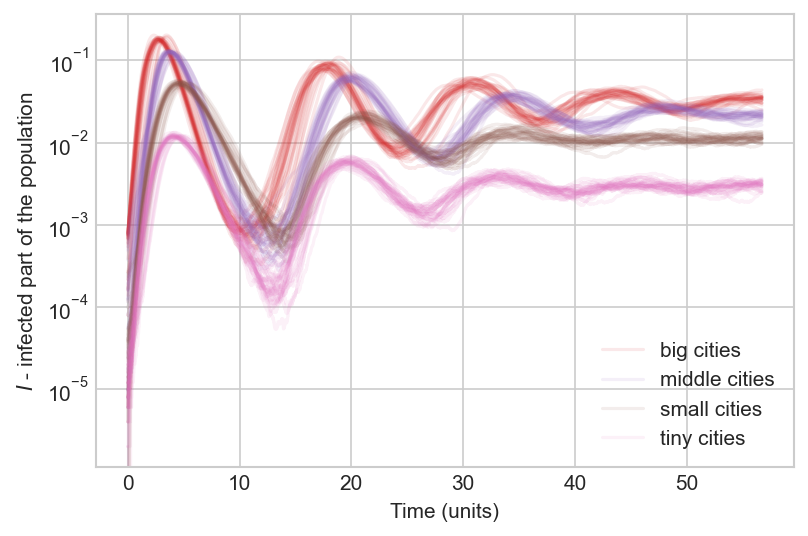

In [8]:
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI1)):
    plt.plot(t, i,color='C3', alpha=0.1, label=None if n else f'big cities')
for n,(t,i) in enumerate(zip(qT,qI2)):
    plt.plot(t, i,color='C4', alpha=0.1, label=None if n else f'middle cities')
for n,(t,i) in enumerate(zip(qT,qI3)):
    plt.plot(t, i,color='C5', alpha=0.1, label=None if n else f'small cities')
for n,(t,i) in enumerate(zip(qT,qI4)):
    plt.plot(t, i,color='C6', alpha=0.1, label=None if n else f'tiny cities')
plt.legend(loc='lower right')
ax.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

It is interesting to note that the tiny cities have the smallest phase delay from the big ones, probably due to an absence of internal dynamics.

The percent of the population infected after 60 units of time varies significantly between cities of different sizes.

In [9]:
print(f'big cities {1-np.mean(qS1.T[-1]):.1%}%\nmiddle cities {1-np.mean(qS2.T[-1]):.1%}')
print(f'small cities {1-np.mean(qS3.T[-1]):.1%}\ntiny cities {1-np.mean(qS4.T[-1]):.1%}')

big cities 83.1%%
middle cities 72.8%
small cities 48.2%
tiny cities 16.0%


As a result, half the population, particularly those living in small and tiny cities, may have little support for public measures to stop the disease's spread.

Of course, the effect is heavily influenced by the $r_0$ scaling exponent, $\theta_r$, but we went with a moderate value of 0.1. A higher value of 0.167 (1/6) is more commonly found in the literature, which would result in a stronger effect.

## The phenomenological dynamics of the virus variants' $r_0$ changes (mutations model)

Mutations in the genome of the virus are described as the wandering of a random point across the virus's fitness landscape. The 3D Rosenbrock function $f_r(x,y,z)$ was chosen as the basis for the landscape. Thus, all the genetic information of the virus strain is given by the coordinates $x,y,z$. For these coordinates, the unnormalized $r_0$ coefficient is calculated by the formula:
$$c_u(x,y,z)=\frac{d}{f_r(x,y,z)+1}$$ 
where $d=3$ is the dimension of the fitness landscape. The $r_0$ of the strain  is given by the formula:
$$r_0(x,y,z)=r_0^i \frac{c_u(x,y,z)}{c_u(0,0,0)}$$
where $r_0^i$ is the initial strain $r_0$. For the initial strain, the genetic information is $(0,0,0)$.

When a descendant buds from the current strain, it receives genetic information slightly shifted on the fitness landscape:
$$(x,y,z)_{descendant}=(x,y,z)+s\cdot (\xi_x,\xi_y,\xi_z)$$
and $\xi_x,\xi_y,\xi_z$ are stochastic values with independent standard normal distributions; $s$ is some step size.

The step size is small in most cases, but with a probability of nonneutral mutation (defined by the nnmp /nonneutral_mutation_prob parameter), it gets quite large. So in most cases, descendant strain $r_0$ is almost the same as parent strain, and with the probability of a nonneutral mutation, it can be quite different. 

Below is the country-level model demonstrated above with a nonnutral mutation probability equal to 1/8.


In [10]:
T=120.0
is_country_level = 1
additional_output = 1
exec_SIR(r0_0,I0,τ,vs0,vb0,ps=2000000,T=T,mtl=min_step_n,
         exec_type=0, #indicates that model type defined by combination of another flags
         is_country=is_country_level,ao=additional_output,
         s_rate=0.08,pii=0.0,ilp=2.0, #immunity decline parameters
         nnmp=1./8., #nonneutral mutation probability
         #below cities' population parameters
         cn=number_of_cities,ze=zipf_exponent, 
         θ=0.1,θ_r=0.1,θ_v=0.05,
         isp=intercity_spread_probability)

0

In [11]:
qT,qS1,qS2,qS3,qS4,qI1,qI2,qI3,qI4=quartile_dynamics_from_file(I0)

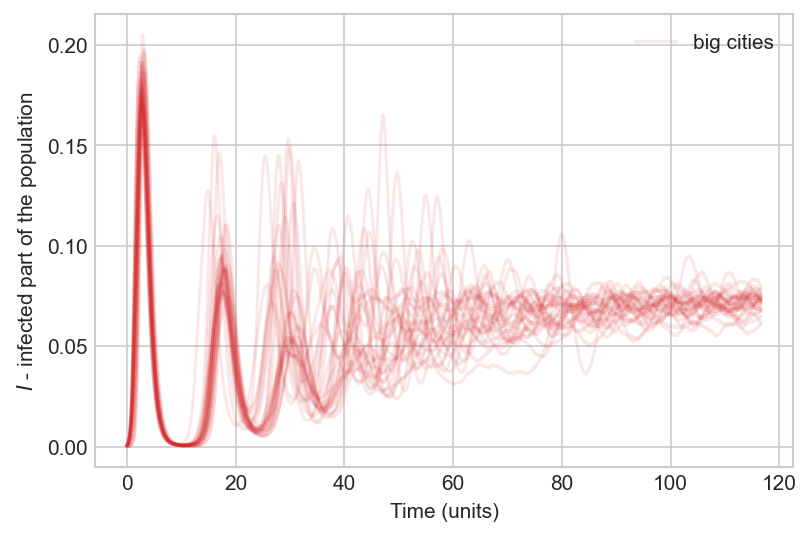

In [12]:
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI1)):
    plt.plot(t, i,color='C3', alpha=0.1, label=None if n else f'big cities')
plt.legend(loc='upper right')
#x.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

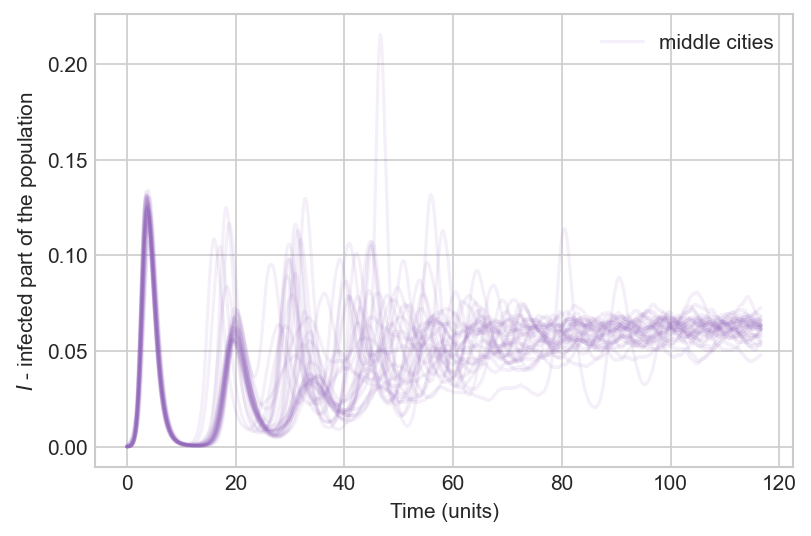

In [13]:
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI2)):
    plt.plot(t, i,color='C4', alpha=0.1, label=None if n else f'middle cities')
plt.legend(loc='upper right')
#x.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

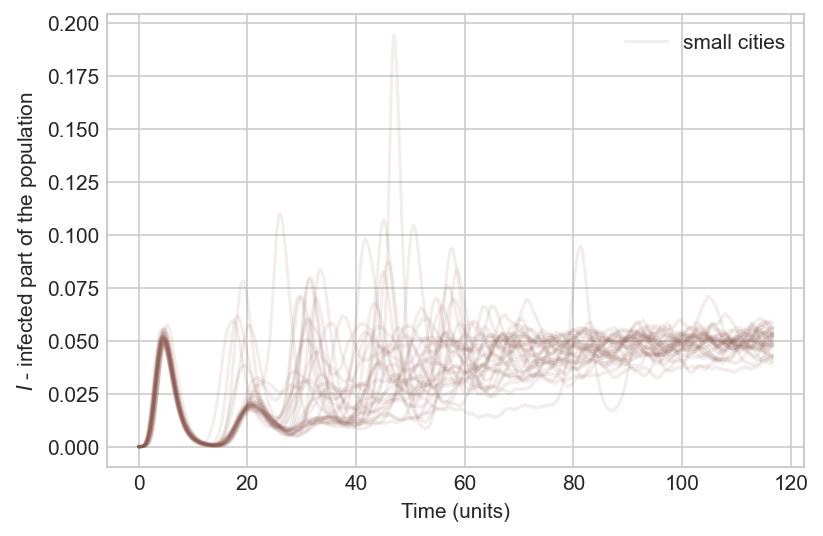

In [14]:
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI3)):
    plt.plot(t, i,color='C5', alpha=0.1, label=None if n else f'small cities')
plt.legend(loc='upper right')
#x.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()

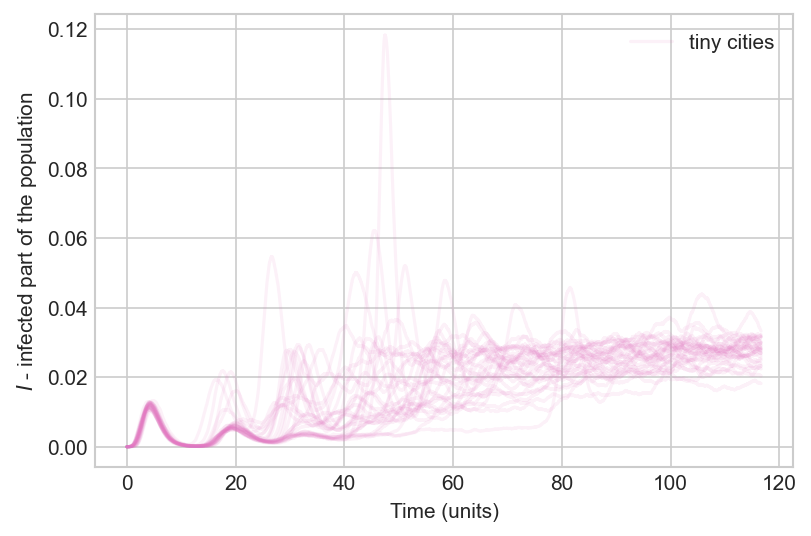

In [15]:
fig, ax = plt.subplots(dpi=150)
for n,(t,i) in enumerate(zip(qT,qI4)):
    plt.plot(t, i,color='C6', alpha=0.1, label=None if n else f'tiny cities')
plt.legend(loc='upper right')
#x.set_yscale('log')
ax.set_xlabel(f'Time (units)')
ax.set_ylabel(f'$I$ - infected part of the population')
plt.show()